In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import LineString
import branca
import folium
import matplotlib.dates as mdates
from datetime import datetime, date, timedelta

In [2]:
# Full database
# df is still the sample csv, need to be changed with the full dataset filtered on stations from Rotterdam to the Hague
df = pd.read_csv('data/data_NS_filtered.csv', sep=";") 
# Codes of stations associated to their commercial name
stations_codes = pd.read_excel("data/data_stations_codes.xlsx")
# GeoJson files that contains the geometry of the location of station
gdf_points = gpd.read_file("data/data_stations_geometry.geojson")

df["UITVOERTIJD_VERTREK"] = pd.to_timedelta(df["UITVOERTIJD_VERTREK"].str.split('.').str[0])
df['PLANTIJD_VERTREK'] = pd.to_timedelta(df['PLANTIJD_VERTREK'].str.split('.').str[0])
df['UITVOERTIJD_AANKOMST'] = pd.to_timedelta(df['UITVOERTIJD_AANKOMST'].str.split('.').str[0])
    
#Small database for testing
#df= df.head(100)
display (df)

,DAGNR,WEEK_DAG_NR,TRAJECT,DAGDEELTREIN,TREINSERIEBASIS,PLANTIJD_VERTREK,UITVOERTIJD_AANKOMST,UITVOERTIJD_VERTREK,BEWEGINGNUMMER,REALISATIE,PROGNOSE_REIZEN,AFWIJKING,station1,station2,Cancelled,ExtraTrain,delay
0,1,6,Shl_Ledn,Weekend,700.0,0 days 05:57:00,0 days 06:16:12,0 days 05:57:26,710,40.525088,96.10463,1.372373,Shl,Ledn,False,False,00:00:00
1,1,6,Ledn_Gvc,Weekend,700.0,0 days 06:15:00,0 days 06:28:32,0 days 06:17:53,710,33.706422,59.84863,0.776189,Ledn,Gvc,False,False,00:02:53
2,1,6,Shl_Ledn,Weekend,700.0,0 days 06:57:00,0 days 07:17:18,0 days 06:57:37,714,66.828816,90.66623,0.356834,Shl,Ledn,False,False,00:00:00
3,1,6,Ledn_Gvc,Weekend,700.0,0 days 07:15:00,0 days 07:29:32,0 days 07:18:45,714,65.882354,72.53823,0.101067,Ledn,Gvc,False,False,00:03:45
4,1,6,Shl_Ledn,Weekend,700.0,0 days 07:57:00,0 days 08:17:35,0 days 07:57:11,718,136.729115,192.18303,0.405653,Shl,Ledn,False,False,00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104566,30,7,Shl_Hfd,Weekend,800000.0,0 days 21:38:00,NaT,NaT,803079,NaN,0.00000,100.000000,Shl,Hfd,True,False,NaN
104567,30,7,Shl_Hfd,Weekend,800000.0,0 days 22:08:00,NaT,NaT,803081,NaN,0.00000,100.000000,Shl,Hfd,True,False,NaN
104568,30,7,Shl_Hfd,Weekend,800000.0,0 days 22:38:00,NaT,NaT,803083,NaN,0.00000,100.000000,Shl,Hfd,True,False,NaN
104569,30,7,Shl_Hfd,Weekend,800000.0,0 days 23:08:00,NaT,NaT,803085,NaN,0.00000,100.000000,Shl,Hfd,True,False,NaN


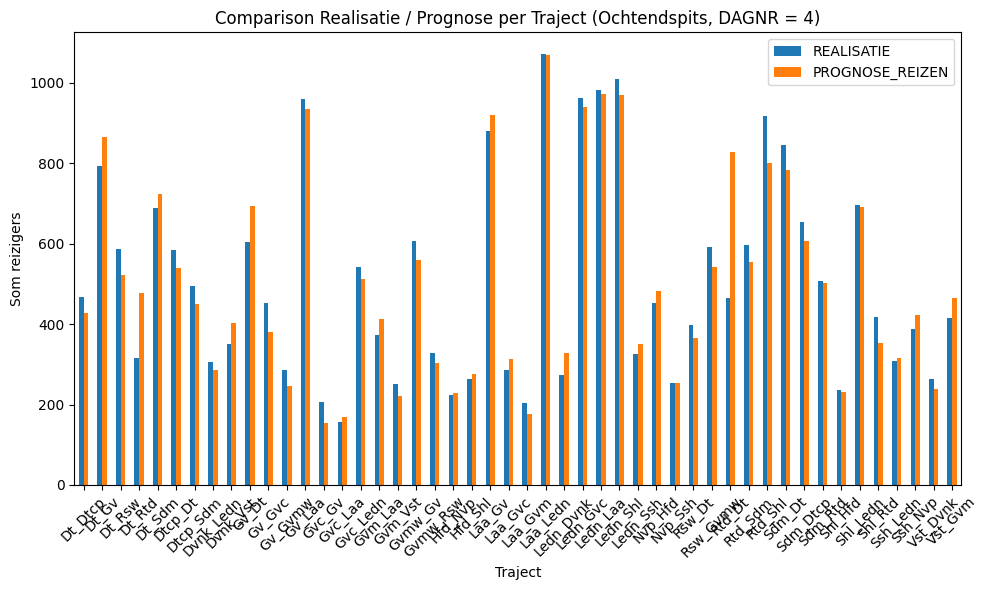

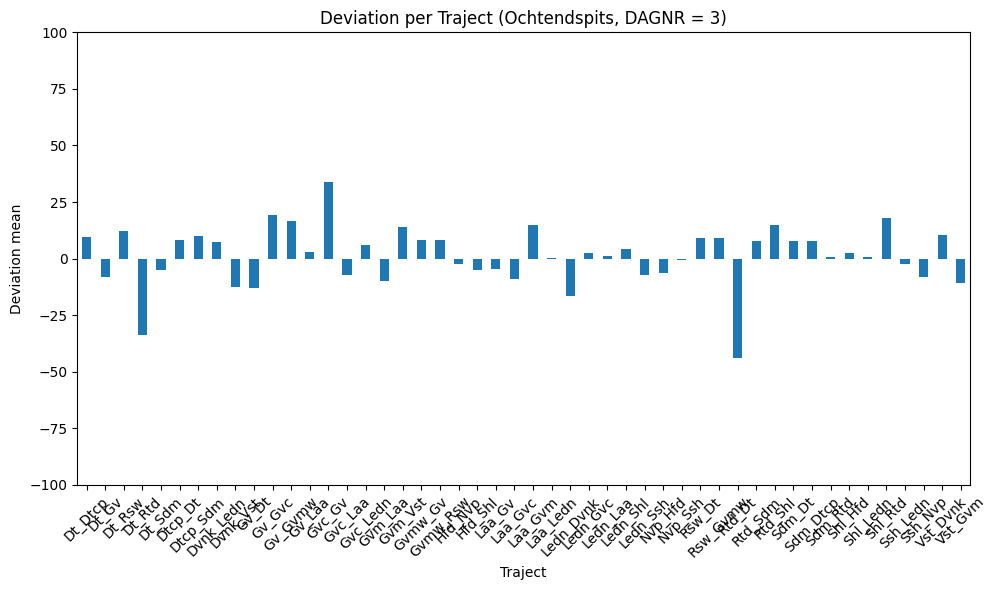

In [32]:

df_dag3 = df[(df["DAGDEELTREIN"] == "Ochtendspits") & (df["DAGNR"] == 4) & (df["Cancelled"] == False) ]

traject_df = (df_dag3.groupby("TRAJECT", as_index=True)[["REALISATIE", "PROGNOSE_REIZEN"]].mean())

traject_df["AFWIJKING"] = ((traject_df["REALISATIE"] - traject_df["PROGNOSE_REIZEN"])/ traject_df["PROGNOSE_REIZEN"]) * 100

traject_df[["REALISATIE", "PROGNOSE_REIZEN"]].plot(kind="bar", figsize=(10,6))

plt.title("Comparison Realisatie / Prognose per Traject (Ochtendspits, DAGNR = 4)")
plt.xlabel("Traject")
plt.ylabel("Som reizigers")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

traject_df["AFWIJKING"].plot(kind="bar", figsize=(10,6))
plt.title("Deviation per Traject (Ochtendspits, DAGNR = 3)")
plt.xlabel("Traject")
plt.ylabel("Deviation mean")
plt.xticks(rotation=45)
plt.tight_layout()
plt.ylim(-100, 100)
plt.show()



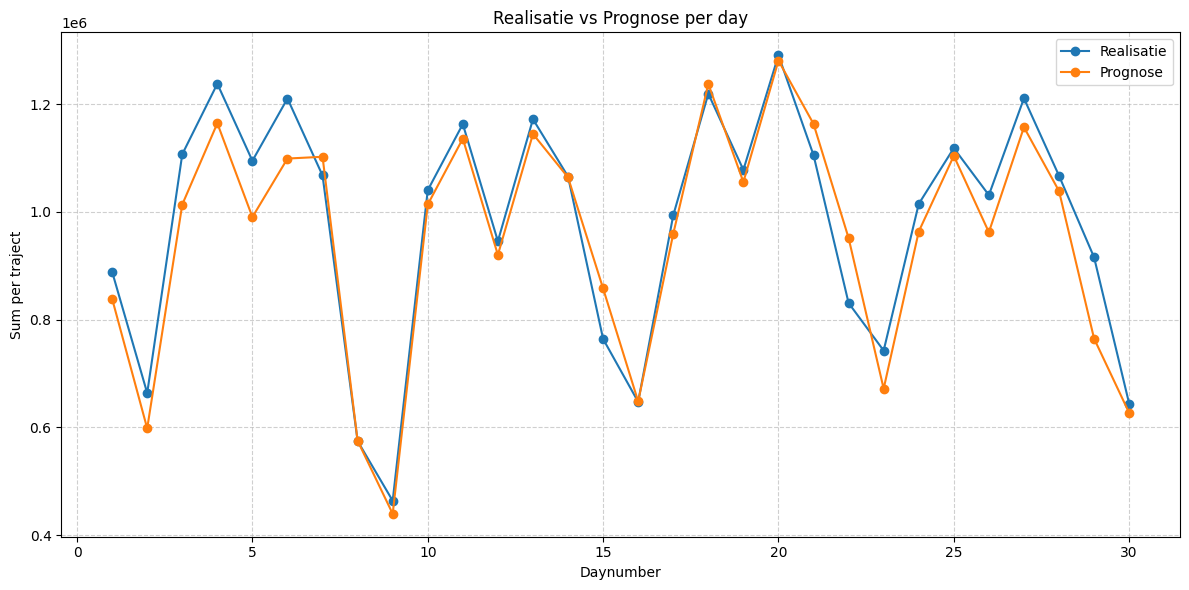

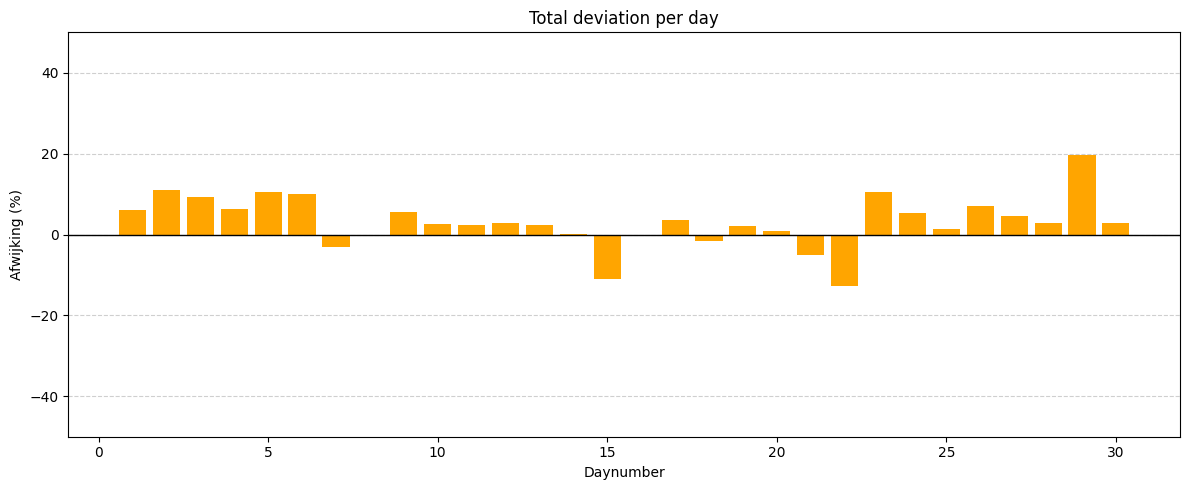

Absolute gemiddelde afwijking: 5.44%


In [34]:
df_filtered = df[(df["Cancelled"] == False)]
dag_totaal = (df_filtered.groupby("DAGNR")[["REALISATIE", "PROGNOSE_REIZEN"]].sum())
dag_totaal["AFWIJKING_%"] = ((dag_totaal["REALISATIE"] - dag_totaal["PROGNOSE_REIZEN"])/ dag_totaal["PROGNOSE_REIZEN"]) * 100

plt.figure(figsize=(12,6))
plt.plot(dag_totaal.index, dag_totaal["REALISATIE"], label="Realisatie", marker="o")
plt.plot(dag_totaal.index, dag_totaal["PROGNOSE_REIZEN"], label="Prognose", marker="o")
plt.title("Realisatie vs Prognose per day")
plt.xlabel("Daynumber")
plt.ylabel("Sum per traject")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,5))
plt.bar(dag_totaal.index, dag_totaal["AFWIJKING_%"], color="orange")
plt.title("Total deviation per day")
plt.xlabel("Daynumber")
plt.ylabel("Afwijking (%)")
plt.ylim(-50, 50)
plt.axhline(0, color='black', linewidth=1)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

Deviation = dag_totaal["AFWIJKING_%"].abs().mean()
print(f"Absolute gemiddelde afwijking: {Deviation:.2f}%")

#display (dag_totaal)

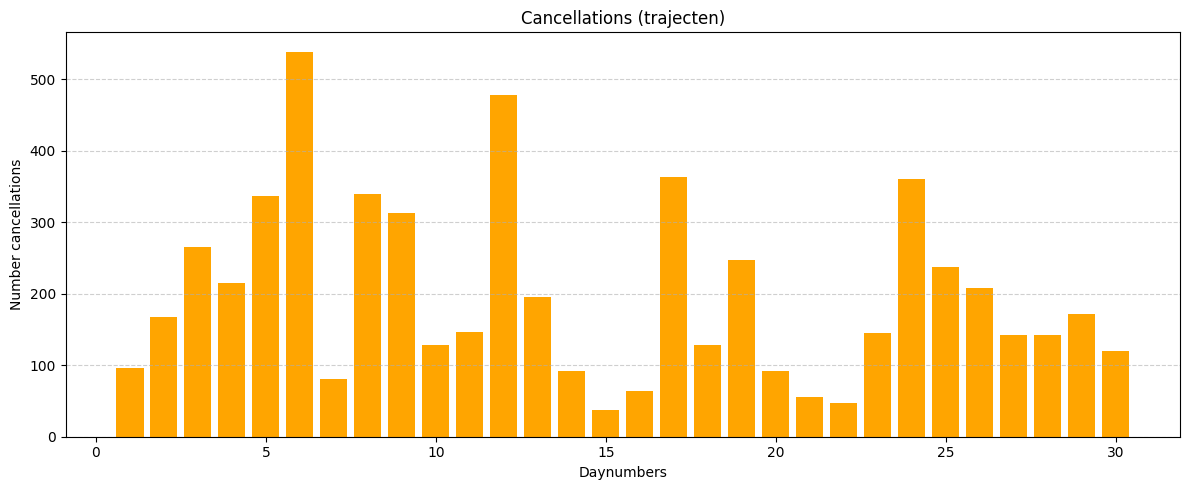

In [19]:
df_cancel = df

# 🔹 Tel aantal geannuleerde ritten per dag
cancellations_per_day = (df_cancel[df_cancel["Cancelled"] == True].groupby("DAGNR").size().reindex(range(1, 32)))


plt.figure(figsize=(12,5))
plt.bar(cancellations_per_day.index, cancellations_per_day.values, color="orange")
plt.title("Cancellations (trajecten)")
plt.xlabel("Daynumbers")
plt.ylabel("Number cancellations")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()



In [6]:
df2 = pd.read_csv("data/Train_distances.csv")

df2.head()

stations = [
    "Dvnk", "Dt", "Dtcp", "Gvc", "Gv", "Laa", "Gvm", "Gvmw", 
    "Hfd", "Ledn", "Nvp", "Rsw", "Rtd", "Ssh", "Sdm", "Shl", "Vst"
]

stations_lower = [s.lower() for s in stations]
df2.columns = [c.lower()for c in df2.columns]

df2["station"] = df2["station"].str.lower()
df2_filtered = df2[df2["station"].isin(stations_lower)]

cols_to_keep = ["station"] + [c for c in df2.columns if c in stations_lower]
df2_filtered = df2_filtered[cols_to_keep]

df2_filtered = df2_filtered.reset_index(drop=True)

display(df2_filtered)


,station,dt,dtcp,dvnk,gv,gvc,gvm,gvmw,hfd,laa,ledn,nvp,rsw,rtd,sdm,shl,ssh,vst
0,dt,XXX,1,21,8,9,13,7,48,10,24,43,5,14,10,53,32,19
1,dtcp,1,XXX,22,9,10,14,8,49,11,25,44,6,13,9,54,33,20
2,dvnk,21,22,XXX,13,12,8,14,27,11,3,22,16,35,31,32,11,2
3,gv,8,9,13,XXX,1,5,1,40,2,16,35,3,22,18,45,24,11
4,gvc,9,10,12,1,XXX,4,2,39,1,15,34,4,23,19,44,23,10
5,gvm,13,14,8,5,4,XXX,6,35,3,11,30,8,27,23,40,19,6
6,gvmw,7,8,14,1,2,6,XXX,41,3,17,36,2,21,17,46,25,12
7,hfd,48,49,27,40,39,35,41,XXX,38,24,5,43,62,58,5,16,29
8,laa,10,11,11,2,1,3,3,38,XXX,14,33,5,24,20,43,22,9
9,ledn,24,25,3,16,15,11,17,24,14,XXX,19,19,38,34,29,8,5


In [46]:
import pandas as pd

distances = df2_filtered.set_index("station")
trips = pd.read_csv("data/data_NS_filtered.csv", sep=";")

trips = trips[trips["DAGNR"] == 2]

trips["station1"] = trips["station1"].str.lower()
trips["station2"] = trips["station2"].str.lower()

def get_distance(row):
    s1, s2 = row["station1"], row["station2"]
    try:
        val = distances.loc[s1, s2]
    except KeyError:
        return None
    if val == "XXX":
        return 0
    return float(val)

trips["afstand_km"] = trips.apply(get_distance, axis=1)

trips["passagiers_km"] = trips["REALISATIE"] * trips["afstand_km"]

trips["passagiers_km"] = trips["passagiers_km"].round(2)

display(trips[["station1", "station2", "REALISATIE",  "afstand_km", "passagiers_km",]])

print("Totale afstand (km):", trips["afstand_km"].sum())
print("Totale passagiers-km:", trips["passagiers_km"].sum())




,station1,station2,REALISATIE,afstand_km,passagiers_km
2706,shl,ledn,59.126592,29.0,1714.67
2707,ledn,gvc,20.603867,15.0,309.06
2708,shl,ledn,121.143386,29.0,3513.16
2709,ledn,gvc,100.890603,15.0,1513.36
2710,shl,ledn,277.063764,29.0,8034.85
...,...,...,...,...,...
5417,laa,gv,404.187090,2.0,808.37
5418,ledn,laa,428.682368,14.0,6001.55
5419,sdm,rtd,317.991531,4.0,1271.97
5420,shl,ledn,383.399712,29.0,11118.59


Totale afstand (km): 30004.0
Totale passagiers-km: 8174592.799999999
